# Importing libraries

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import numpy as np
import seaborn as sns

# Data mounting


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


# Data pre-processing

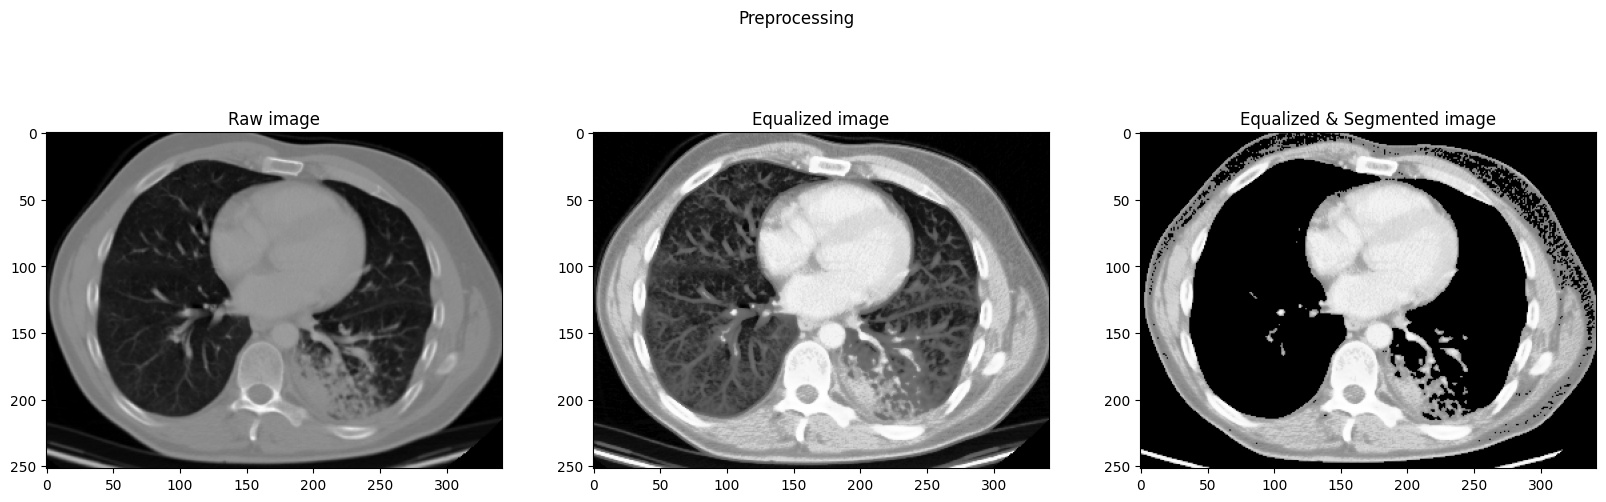

In [ ]:
img = cv2.imread('/content/drive/MyDrive/dataset/rawData/squamous.cell.carcinoma/squamous.cell.carcinoma1.png', 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [ ]:
print(os.getcwd(), os.listdir())
DIR = '/content/drive/MyDrive/dataset/rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = './data'

/content ['.config', 'drive', 'sample_data']


In [ ]:
if not os.path.exists(DEST_DIR):
    !mkdir data && cd data && mkdir cancerous && mkdir non-cancerous

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = curr.replace('/content/drive/MyDrive/dataset/rawData/normal', '/content/drive/MyDrive/dataset/data/non-cancerous')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('/content/drive/MyDrive/dataset/rawData/adenocarcinoma', '/content/drive/MyDrive/dataset/data/cancerous')
            imgDest = imgDest.replace('/content/drive/MyDrive/dataset/rawData/large.cell.carcinoma', '/content/drive/MyDrive/dataset/data/cancerous')
            imgDest = imgDest.replace('/content/drive/MyDrive/dataset/rawData/squamous.cell.carcinoma', '/content/drive/MyDrive/dataset/data/cancerous')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at ./data


# Comparison between processed and unprocessed image

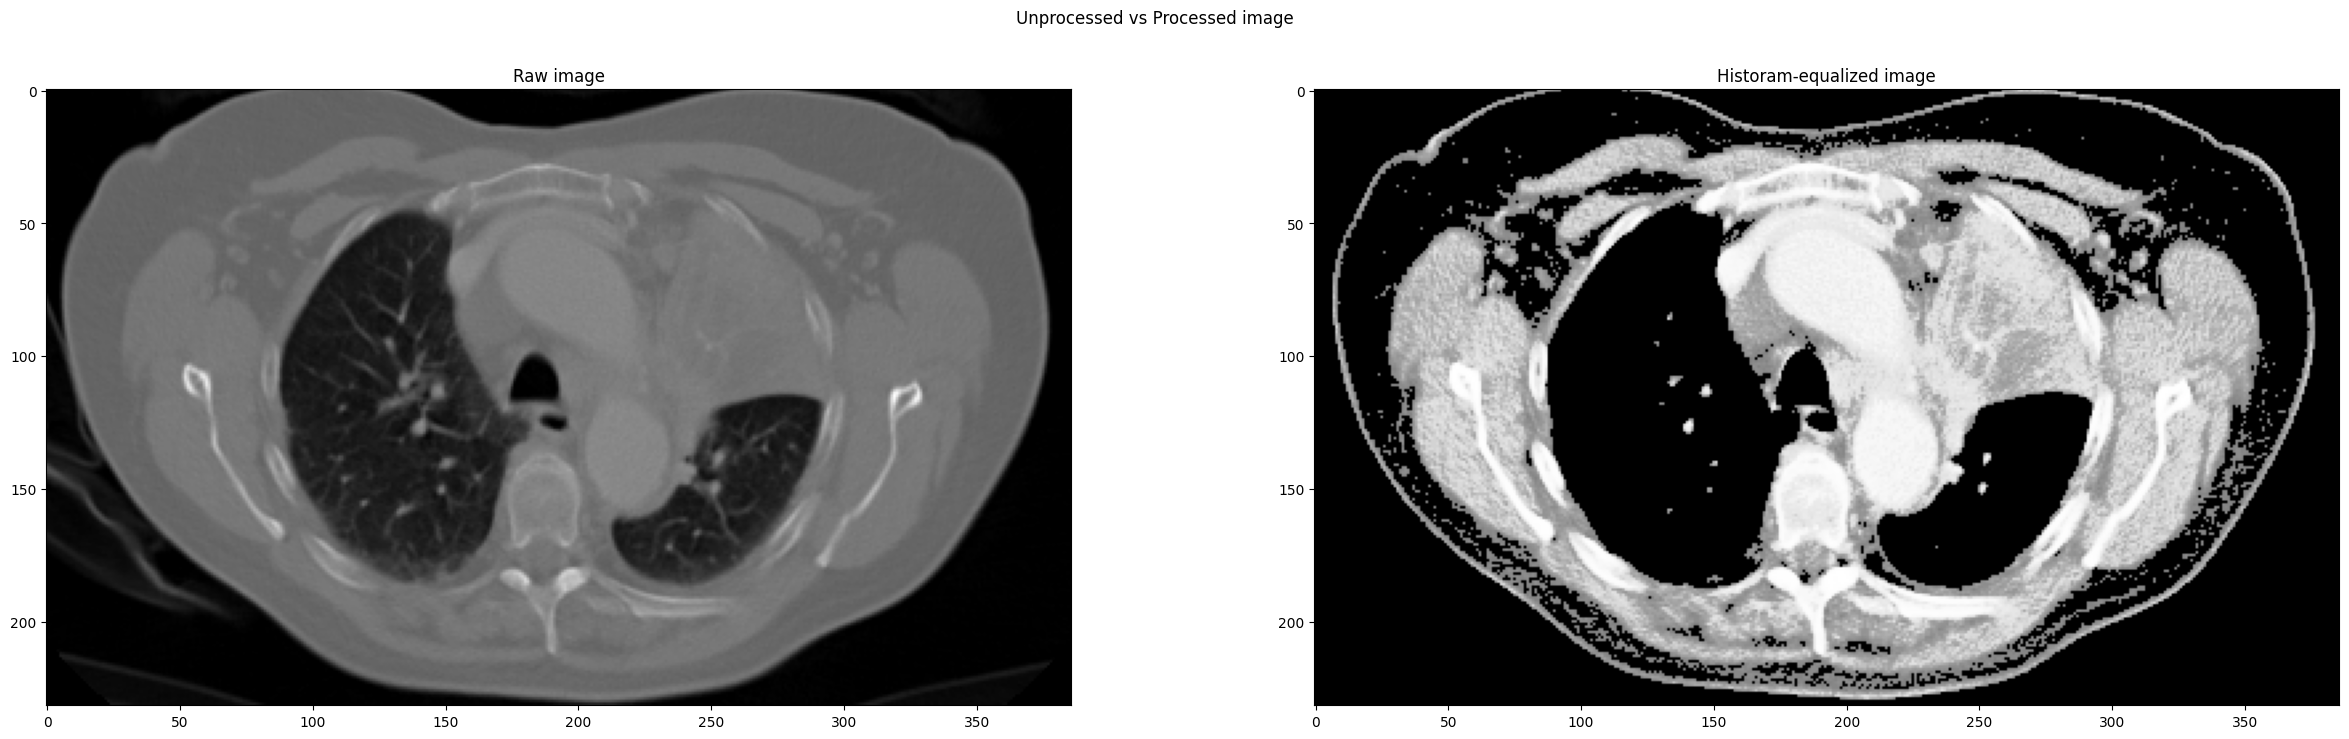

In [ ]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], '/content/drive/MyDrive/dataset/rawData/adenocarcinoma/adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', '/content/drive/MyDrive/dataset/data/cancerous/adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

# Splitting processed data 

In [ ]:
FINAL_DIR = '/content/drive/MyDrive/dataset/processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2))

Copying files: 0 files [00:02, ? files/s]


In [ ]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,                  
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/processedData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/processedData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/processedData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


# Neural Network 

In [ ]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),  
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

def plot_history(hist, name):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].plot(hist.history['Accuracy'])
  axs[0].plot(hist.history['val_Accuracy'])
  axs[0].set_title(f'{name} Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'val', 'F1', 'Recall'], loc='upper left')

  axs[1].plot(hist.history['loss'])
  axs[1].plot(hist.history['val_loss'])
  axs[1].set_title(f'{name} Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'val'], loc='upper left')
  
  axs[2].plot(hist.history['Precision'])
  axs[2].plot(hist.history['val_Precision'])
  axs[2].set_title(f'{name} Precision')
  axs[2].set_ylabel('Precision')
  axs[2].set_xlabel('Epoch')
  axs[2].legend(['train', 'val'], loc='upper left')

  plt.show()

# CNN

In [ ]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN_history = CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.5787 - Accuracy: 0.7754 - Precision: 0.3158 - Recall: 0.0400 - AUC: 0.5421 - F1: 0.0282

22/22 [==============================] - 117s 5s/step - loss: 0.5787 - Accuracy: 0.7754 - Precision: 0.3158 - Recall: 0.0400 - AUC: 0.5421 - F1: 0.0282 - val_loss: 0.6032 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.7299 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5317 - Accuracy: 0.7840 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.5705 - F1: 0.0000e+00

22/22 [==============================] - 13s 584ms/step - loss: 0.5317 - Accuracy: 0.7840 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.5705 - F1: 0.0000e+00 - val_loss: 0.5241 - val_Accuracy: 0.8384 - val_Precision: 1.0000 - val_Recall: 0.2381 - val_AUC: 0.8483 - val_F1: 0.2854 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4613 - Accuracy: 0.7954 - Precision: 0.7059 - Recall: 0.0800 - AUC: 0.7332 - F1: 0.1241

22/22 [==============================] - 13s 596ms/step - loss: 0.4613 - Accuracy: 0.7954 - Precision: 0.7059 - Recall: 0.0800 - AUC: 0.7332 - F1: 0.1241 - val_loss: 0.3203 - val_Accuracy: 0.8889 - val_Precision: 0.7778 - val_Recall: 0.6667 - val_AUC: 0.8944 - val_F1: 0.5268 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4145 - Accuracy: 0.8155 - Precision: 0.6207 - Recall: 0.3600 - AUC: 0.8095 - F1: 0.4368

22/22 [==============================] - 13s 587ms/step - loss: 0.4145 - Accuracy: 0.8155 - Precision: 0.6207 - Recall: 0.3600 - AUC: 0.8095 - F1: 0.4368 - val_loss: 0.5298 - val_Accuracy: 0.6768 - val_Precision: 0.3962 - val_Recall: 1.0000 - val_AUC: 0.9744 - val_F1: 0.4337 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3681 - Accuracy: 0.8340 - Precision: 0.6848 - Recall: 0.4200 - AUC: 0.8525 - F1: 0.4606

22/22 [==============================] - 13s 572ms/step - loss: 0.3681 - Accuracy: 0.8340 - Precision: 0.6848 - Recall: 0.4200 - AUC: 0.8525 - F1: 0.4606 - val_loss: 0.3314 - val_Accuracy: 0.8081 - val_Precision: 0.5250 - val_Recall: 1.0000 - val_AUC: 0.9756 - val_F1: 0.7606 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3609 - Accuracy: 0.8441 - Precision: 0.6881 - Recall: 0.5000 - AUC: 0.8630 - F1: 0.5077

22/22 [==============================] - 12s 547ms/step - loss: 0.3609 - Accuracy: 0.8441 - Precision: 0.6881 - Recall: 0.5000 - AUC: 0.8630 - F1: 0.5077 - val_loss: 0.2592 - val_Accuracy: 0.9192 - val_Precision: 1.0000 - val_Recall: 0.6190 - val_AUC: 0.9683 - val_F1: 0.5722 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3058 - Accuracy: 0.8784 - Precision: 0.8571 - Recall: 0.5200 - AUC: 0.9075 - F1: 0.6249

22/22 [==============================] - 13s 594ms/step - loss: 0.3058 - Accuracy: 0.8784 - Precision: 0.8571 - Recall: 0.5200 - AUC: 0.9075 - F1: 0.6249 - val_loss: 0.1655 - val_Accuracy: 0.9394 - val_Precision: 0.8000 - val_Recall: 0.9524 - val_AUC: 0.9719 - val_F1: 0.6585 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2709 - Accuracy: 0.8970 - Precision: 0.8197 - Recall: 0.6667 - AUC: 0.9244 - F1: 0.6733

22/22 [==============================] - 13s 594ms/step - loss: 0.2709 - Accuracy: 0.8970 - Precision: 0.8197 - Recall: 0.6667 - AUC: 0.9244 - F1: 0.6733 - val_loss: 0.1178 - val_Accuracy: 0.9596 - val_Precision: 0.9048 - val_Recall: 0.9048 - val_AUC: 0.9908 - val_F1: 0.9167 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2897 - Accuracy: 0.8698 - Precision: 0.7287 - Recall: 0.6267 - AUC: 0.9145 - F1: 0.6386

22/22 [==============================] - 13s 608ms/step - loss: 0.2897 - Accuracy: 0.8698 - Precision: 0.7287 - Recall: 0.6267 - AUC: 0.9145 - F1: 0.6386 - val_loss: 0.2637 - val_Accuracy: 0.8788 - val_Precision: 1.0000 - val_Recall: 0.4286 - val_AUC: 0.9472 - val_F1: 0.4514 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2975 - Accuracy: 0.8798 - Precision: 0.8113 - Recall: 0.5733 - AUC: 0.9102 - F1: 0.6426

22/22 [==============================] - 13s 606ms/step - loss: 0.2975 - Accuracy: 0.8798 - Precision: 0.8113 - Recall: 0.5733 - AUC: 0.9102 - F1: 0.6426 - val_loss: 0.0990 - val_Accuracy: 0.9596 - val_Precision: 0.9048 - val_Recall: 0.9048 - val_AUC: 0.9921 - val_F1: 0.6769 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2489 - Accuracy: 0.8913 - Precision: 0.7984 - Recall: 0.6600 - AUC: 0.9392 - F1: 0.6797

22/22 [==============================] - 13s 582ms/step - loss: 0.2489 - Accuracy: 0.8913 - Precision: 0.7984 - Recall: 0.6600 - AUC: 0.9392 - F1: 0.6797 - val_loss: 0.1276 - val_Accuracy: 0.9495 - val_Precision: 0.9444 - val_Recall: 0.8095 - val_AUC: 0.9853 - val_F1: 0.6544 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2250 - Accuracy: 0.9084 - Precision: 0.8525 - Recall: 0.6933 - AUC: 0.9508 - F1: 0.7474

22/22 [==============================] - 13s 592ms/step - loss: 0.2250 - Accuracy: 0.9084 - Precision: 0.8525 - Recall: 0.6933 - AUC: 0.9508 - F1: 0.7474 - val_loss: 0.1903 - val_Accuracy: 0.9293 - val_Precision: 0.7692 - val_Recall: 0.9524 - val_AUC: 0.9847 - val_F1: 0.6291 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.2322 - Accuracy: 0.8999 - Precision: 0.8175 - Recall: 0.6867 - AUC: 0.9510 - F1: 0.7223
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 575ms/step - loss: 0.2322 - Accuracy: 0.8999 - Precision: 0.8175 - Recall: 0.6867 - AUC: 0.9510 - F1: 0.7223 - val_loss: 0.1051 - val_Accuracy: 0.9495 - val_Precision: 0.9000 - val_Recall: 0.8571 - val_AUC: 0.9905 - val_F1: 0.6558 - lr: 0.0010
Epoch 13: early stopping


In [ ]:
CNN_scores = CNN.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 64s 11s/step - loss: 0.1694 - Accuracy: 0.9455 - Precision: 0.9024 - Recall: 0.8409 - AUC: 0.9617 - F1: 0.7632


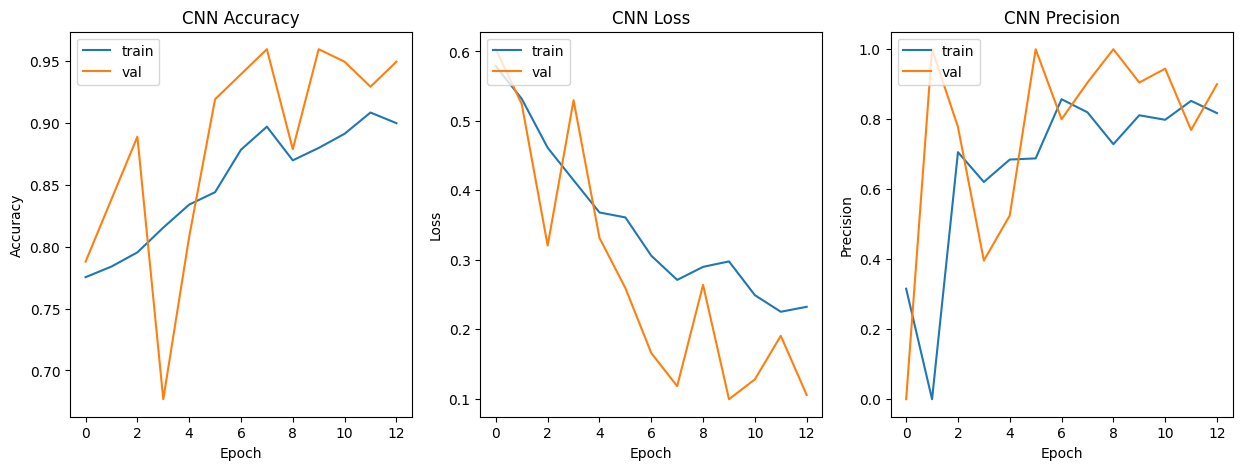

In [ ]:
plot_history(CNN_history, 'CNN')

# Prediction VS Truth

1/1 [==============================] - 0s 24ms/step


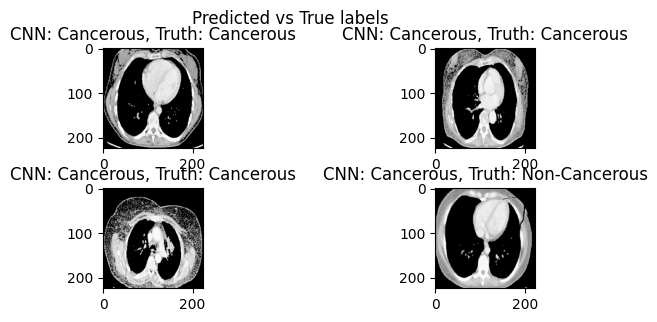

In [ ]:
batch = next(test_dataset)

def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  cnnPred = 0 if CNN.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1

  return f'CNN: {label_dict[cnnPred]}, Truth: {label_dict[int(batch[1][i])]}'

  plt.figure(figsize=(100, 100))

ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][0])
label = predAll(batch, 0)
ax1.set_title(label)


ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[0][5])
label = predAll(batch, 1)
ax2.set_title(label)

ax3 = plt.subplot(2, 2, 3)
plt.imshow(batch[0][2])
label = predAll(batch, 2)
ax3.set_title(label)

ax4 = plt.subplot(2, 2, 4)
plt.imshow(batch[0][3])
label = predAll(batch, 3)
ax4.set_title(label)


plt.suptitle('Predicted vs True labels')

plt.subplots_adjust(left=0.1,
                    bottom=0.4,
                    right=0.99,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()


In [ ]:
eval = [CNN_scores]
eval

[[0.1694493442773819,
  0.9455445408821106,
  0.9024389982223511,
  0.8409090638160706,
  0.961665689945221,
  0.7632459998130798]]

In [ ]:
scores = pd.DataFrame({'Accuracy': [item[1] for item in eval],'Precision': [item[2] for item in eval], 'Recall': [item[3] for item in eval], 'AUC': [item[4] for item in eval], 'F1': [item[5] for item in eval]})
scores

,Accuracy,Precision,Recall,AUC,F1
0,0.945545,0.902439,0.840909,0.961666,0.763246
